In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

# pretrained model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

from tensorflow.keras.preprocessing.image import ImageDataGenerator

[`clear_session`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session)

[`set_memory_growth`](https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth)

In [20]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("OK")
except:
    # Invalid device or cannot modify virtual devices once initialized.
    print("Fail")

Fail


Set the environment variable `TF_CPP_MIN_LOG_LEVEL=3` to filter out info and warning messages.
```python
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
```

Prepare data for the model

In [2]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds = train_gen.flow_from_directory('./clothing-dataset-small/train/', 
                              target_size=(150, 150), 
                                batch_size=32)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation/', 
                              target_size=(150, 150), 
                                batch_size=32,
                                shuffle=False) 

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [4]:
base_model = Xception(
                weights='imagenet', 
                include_top=False,
                input_shape=(150, 150, 3)
)
# use conv.layers of Xception
base_model.trainable = False

In [5]:
inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs, training = False) 

# add pooling
pooling = keras.layers.GlobalAveragePooling2D()
vectors = pooling(base)
outputs = keras.layers.Dense(10)(vectors)

In [6]:
learning_rate=0.001

In [16]:
# Function to create model
def make_model(learning_rate=0.01):
    
    tf.keras.backend.clear_session()
    
    ################
    # base (pre-trained) model
    base_model = Xception(
                    weights='imagenet', 
                    include_top=False,
                    input_shape=(150, 150, 3)
    )
    # use conv.layers of Xception
    base_model.trainable = False
    
    #########################################
    
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training = False) 

    # add pooling
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)
    outputs = keras.layers.Dense(10)(vectors) # outputs of conv.layers
    ####################
    
    model = keras.Model(inputs, outputs)
    
    #########################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    
    return model

### Checkpoints

In [9]:
model = make_model(learning_rate)

In [10]:
model.save_weights('model_v1.h5', save_format='h5')

In [17]:

checkpoint = [
    keras.callbacks.ModelCheckpoint(
        "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
)
]


In [18]:
learning_rate = 0.001

model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[checkpoint]
)

Epoch 1/10


2023-11-20 16:21:58.712724: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-11-20 16:21:59.406339: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-20 16:21:59.406852: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-20 16:21:59.406906: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-11-20 16:21:59.407557: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-20 16:21:59.407624: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


96/96 [==============================] - 22s 173ms/step - loss: 1.1111 - accuracy: 0.6258 - val_loss: 0.7275 - val_accuracy: 0.7625
Epoch 2/10
96/96 [==============================] - 13s 130ms/step - loss: 0.6315 - accuracy: 0.7859 - val_loss: 0.6322 - val_accuracy: 0.7947
Epoch 3/10
96/96 [==============================] - 13s 130ms/step - loss: 0.5165 - accuracy: 0.8240 - val_loss: 0.5906 - val_accuracy: 0.8035
Epoch 4/10
96/96 [==============================] - 12s 128ms/step - loss: 0.4294 - accuracy: 0.8579 - val_loss: 0.5618 - val_accuracy: 0.8270
Epoch 5/10
96/96 [==============================] - 12s 126ms/step - loss: 0.3705 - accuracy: 0.8872 - val_loss: 0.5583 - val_accuracy: 0.8123
Epoch 6/10
96/96 [==============================] - 12s 127ms/step - loss: 0.3306 - accuracy: 0.9016 - val_loss: 0.5570 - val_accuracy: 0.8065
Epoch 7/10
96/96 [==============================] - 12s 128ms/step - loss: 0.2887 - accuracy: 0.9237 - val_loss: 0.5479 - val_accuracy: 0.8211
Epoch 8/10

### Adding more layers

In [21]:
# Function to create model
def make_model(learning_rate=0.01, size_inner=10):
    
    tf.keras.backend.clear_session()
    #################
    # base (pre-trained) model
    base_model = Xception(
                    weights='imagenet', 
                    include_top=False,
                    input_shape=(150, 150, 3)
    )
    # use conv.layers of Xception
    base_model.trainable = False
    
    #########################################
    
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training = False) 

    # add pooling
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)
    # add inner layer
    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)
    # replace vectors with inner layer's outputs
    
    outputs = keras.layers.Dense(10)(inner) # outputs of conv.layers
    ####################
    
    model = keras.Model(inputs, outputs)
    
    #########################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    
    return model

In [22]:
scores = {}
lr = 0.001
# List of learning rates
size_inner = [10, 100, 1000]

for size in size_inner:
    print(size) # accidentially put print(lr)
    
    model = make_model(learning_rate=lr, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history
    
    print()
    print()

0.001
Epoch 1/10
96/96 [==============================] - 16s 140ms/step - loss: 1.6495 - accuracy: 0.4361 - val_loss: 1.2132 - val_accuracy: 0.6217
Epoch 2/10
96/96 [==============================] - 12s 128ms/step - loss: 1.0085 - accuracy: 0.6659 - val_loss: 0.8942 - val_accuracy: 0.7214
Epoch 3/10
96/96 [==============================] - 12s 127ms/step - loss: 0.7604 - accuracy: 0.7526 - val_loss: 0.7494 - val_accuracy: 0.7830
Epoch 4/10
96/96 [==============================] - 12s 129ms/step - loss: 0.6288 - accuracy: 0.7963 - val_loss: 0.6911 - val_accuracy: 0.7654
Epoch 5/10
96/96 [==============================] - 12s 129ms/step - loss: 0.5484 - accuracy: 0.8119 - val_loss: 0.6625 - val_accuracy: 0.7889
Epoch 6/10
96/96 [==============================] - 12s 128ms/step - loss: 0.4810 - accuracy: 0.8475 - val_loss: 0.6294 - val_accuracy: 0.7918
Epoch 7/10
96/96 [==============================] - 12s 127ms/step - loss: 0.4329 - accuracy: 0.8670 - val_loss: 0.6252 - val_accuracy: 

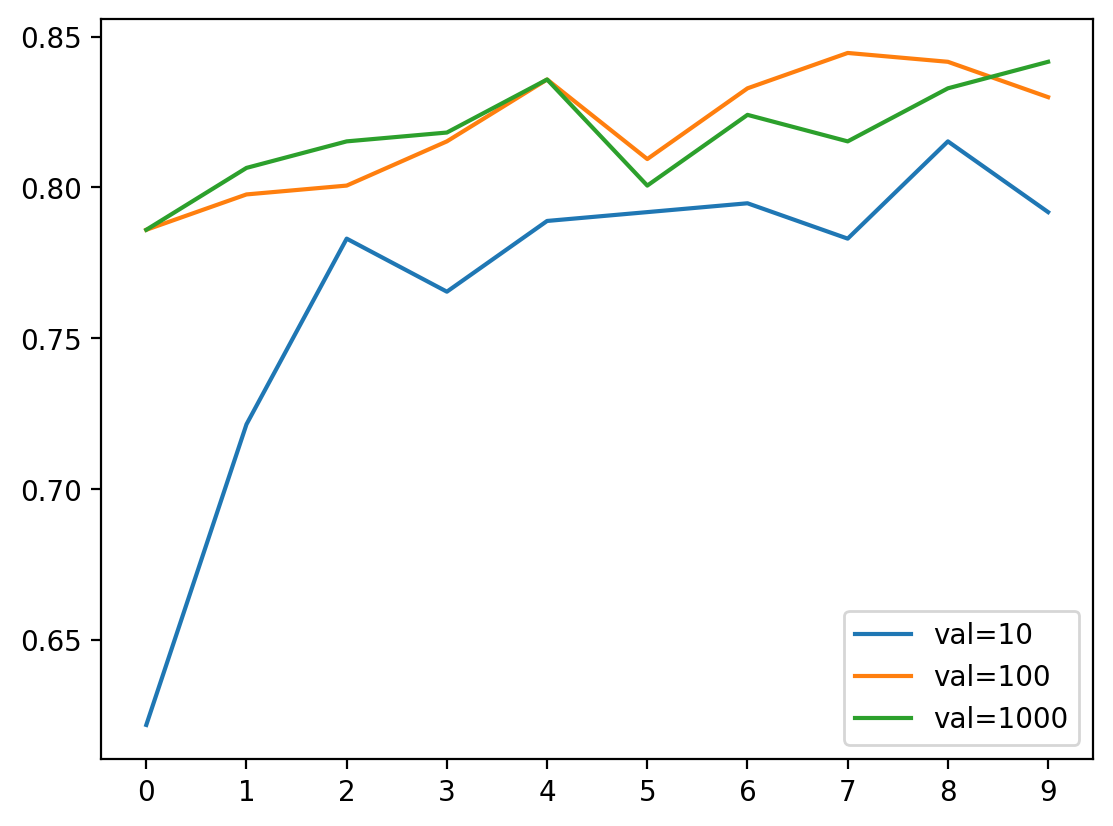

In [23]:
for size, hist in scores.items():
    plt.plot(hist["val_accuracy"], label=("val=%s" % size))
plt.xticks(np.arange(10))
plt.legend()
plt.show()

In [24]:
size = 100

### Regularization and Dropout

```python
tf.keras.layers.Dropout(
    rate, noise_shape=None, seed=None, **kwargs
)
```

Add regularization. `Droprate` - percentage of nodes in the inner layer that will be dropped on each iteration. `Dropout` The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

In [26]:
def make_model(learning_rate=0.001, size_inner=100, droprate=0.5):
    
    tf.keras.backend.clear_session()
    
    ################
    # base (pre-trained) model
    base_model = Xception(
                    weights='imagenet', 
                    include_top=False,
                    input_shape=(150, 150, 3)
    )
    # use conv.layers of Xception
    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [27]:
learning_rate = 0.001
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/30
96/96 [==============================] - 14s 129ms/step - loss: 0.9701 - accuracy: 0.6649 - val_loss: 0.5932 - val_accuracy: 0.7889
Epoch 2/30
96/96 [==============================] - 12s 120ms/step - loss: 0.5122 - accuracy: 0.8308 - val_loss: 0.5959 - val_accuracy: 0.7918
Epoch 3/30
96/96 [==============================] - 12s 121ms/step - loss: 0.3505 - accuracy: 0.8791 - val_loss: 0.5968 - val_accuracy: 0.7918
Epoch 4/30
96/96 [==============================] - 12s 120ms/step - loss: 0.2455 - accuracy: 0.9250 - val_loss: 0.5497 - val_accuracy: 0.8299
Epoch 5/30
96/96 [==============================] - 12s 121ms/step - loss: 0.1737 - accuracy: 0.9550 - val_loss: 0.5692 - val_accuracy: 0.8182
Epoch 6/30
96/96 [==============================] - 12s 121ms/step - loss: 0.1140 - accuracy: 0.9759 - val_loss: 0.5746 - val_accuracy: 0.8182
Epoch 7/30
96/96 [==============================] - 12s 120ms/step - loss: 0.0812 - accuracy: 0.9857 - val_loss: 0.6141 - val_accuracy: 0.

Epoch 28/30
96/96 [==============================] - 12s 123ms/step - loss: 0.0181 - accuracy: 0.9971 - val_loss: 0.7667 - val_accuracy: 0.8358
Epoch 29/30
96/96 [==============================] - 12s 122ms/step - loss: 0.0204 - accuracy: 0.9967 - val_loss: 0.7378 - val_accuracy: 0.8328
Epoch 30/30
96/96 [==============================] - 12s 121ms/step - loss: 0.0249 - accuracy: 0.9935 - val_loss: 0.8230 - val_accuracy: 0.8240


0.5
Epoch 1/30
96/96 [==============================] - 15s 131ms/step - loss: 1.2896 - accuracy: 0.5616 - val_loss: 0.7895 - val_accuracy: 0.7302
Epoch 2/30
96/96 [==============================] - 12s 121ms/step - loss: 0.8471 - accuracy: 0.7050 - val_loss: 0.6660 - val_accuracy: 0.7683
Epoch 3/30
96/96 [==============================] - 12s 122ms/step - loss: 0.7073 - accuracy: 0.7549 - val_loss: 0.6319 - val_accuracy: 0.7801
Epoch 4/30
96/96 [==============================] - 12s 121ms/step - loss: 0.5942 - accuracy: 0.7911 - val_loss: 0.5876 - val_accurac

Epoch 25/30
96/96 [==============================] - 12s 121ms/step - loss: 0.6986 - accuracy: 0.7285 - val_loss: 0.5924 - val_accuracy: 0.8123
Epoch 26/30
96/96 [==============================] - 12s 121ms/step - loss: 0.7007 - accuracy: 0.7285 - val_loss: 0.6108 - val_accuracy: 0.8123
Epoch 27/30
96/96 [==============================] - 12s 123ms/step - loss: 0.6528 - accuracy: 0.7451 - val_loss: 0.6119 - val_accuracy: 0.8006
Epoch 28/30
96/96 [==============================] - 12s 122ms/step - loss: 0.6713 - accuracy: 0.7464 - val_loss: 0.6033 - val_accuracy: 0.8211
Epoch 29/30
96/96 [==============================] - 12s 121ms/step - loss: 0.6328 - accuracy: 0.7490 - val_loss: 0.5818 - val_accuracy: 0.8182
Epoch 30/30
96/96 [==============================] - 12s 122ms/step - loss: 0.6254 - accuracy: 0.7559 - val_loss: 0.5892 - val_accuracy: 0.8387




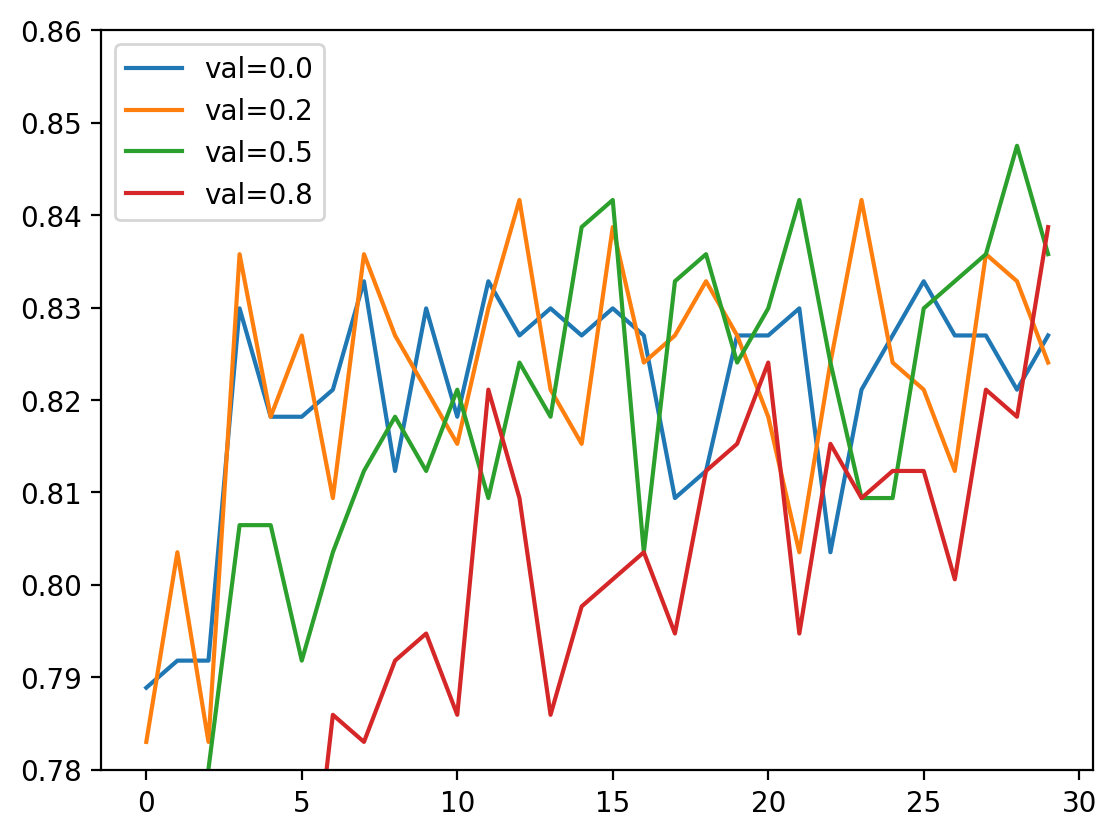

In [30]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.78, 0.86)
plt.legend()
plt.show()

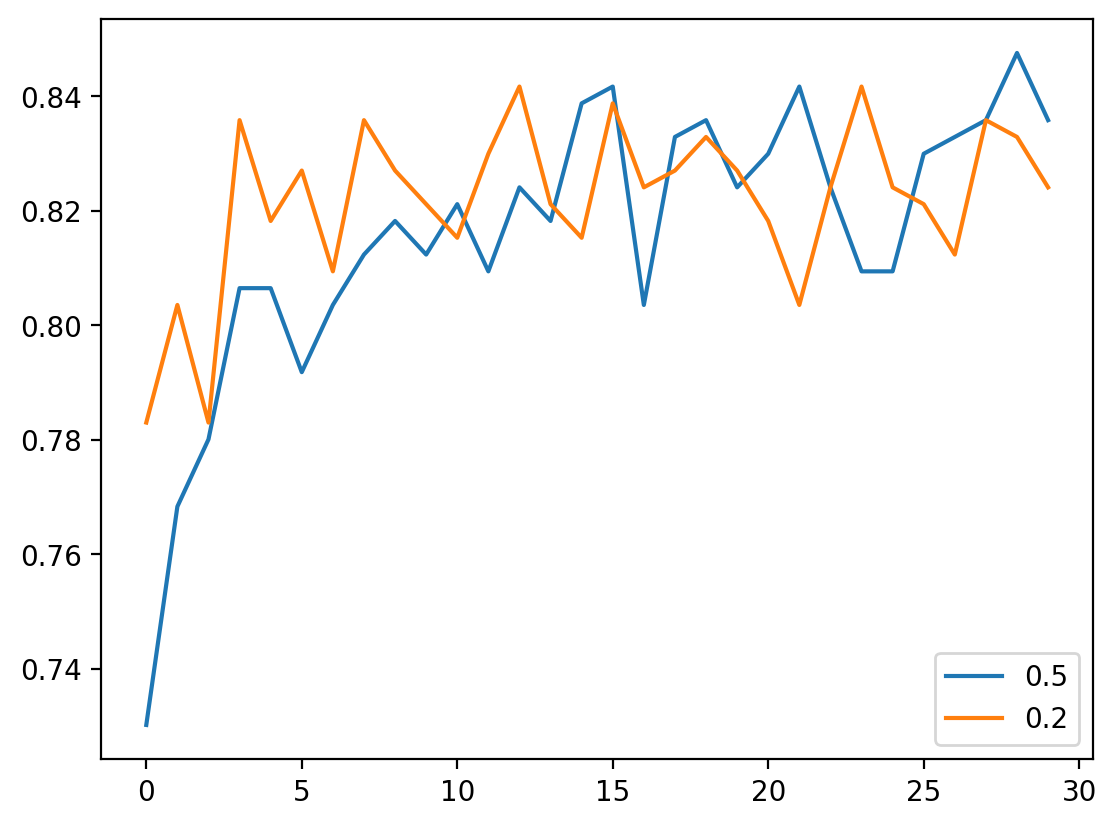

In [31]:
hist = scores[0.5]
plt.plot(hist['val_accuracy'], label=0.5)

hist = scores[0.2]
plt.plot(hist['val_accuracy'], label=0.2)

plt.legend()

In [32]:
drop = 0.2

#### Data Augmentation
generate more images, for example
```python
ImageDataGenerator(rescale=1./255,
                            rotation_range=50,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            fill_mode='nearest'
                            )
```

Note: when applying data augmentation it is better to increase the number of epochs:

```python
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds)
```

### Training and saving the larger model

In [33]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):
    
    # clear the session
    tf.keras.backend.clear_session()
    
    ################
    # base (pre-trained) model
    base_model = Xception(
                    weights='imagenet', 
                    include_top=False,
                    input_shape=(input_size, input_size, 3)
    )
    # use conv.layers of Xception
    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model


In [34]:
input_size = 299

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(input_size, input_size),
    batch_size=32
)


val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [35]:
# create a checkpoint
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

`initial_value_threshold` is a parameter of `keras.callbacks.ModelCheckpoint` Floating point initial "best" value of the metric to be monitored. Only applies if `save_best_value=True`. Only overwrites the model weights already saved if the performance of current model is better than this value.

In [37]:
learning_rate = 0.0005
size = 100
droprate = 0.2

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=25, validation_data=val_ds,
                   callbacks=[checkpoint])

Epoch 1/25
96/96 [==============================] - 75s 758ms/step - loss: 0.9575 - accuracy: 0.6923 - val_loss: 0.5341 - val_accuracy: 0.8387
Epoch 2/25
96/96 [==============================] - 69s 717ms/step - loss: 0.5224 - accuracy: 0.8233 - val_loss: 0.4609 - val_accuracy: 0.8358
Epoch 3/25
96/96 [==============================] - 69s 721ms/step - loss: 0.4171 - accuracy: 0.8595 - val_loss: 0.4009 - val_accuracy: 0.8651
Epoch 4/25
96/96 [==============================] - 70s 724ms/step - loss: 0.3795 - accuracy: 0.8716 - val_loss: 0.4018 - val_accuracy: 0.8622
Epoch 5/25
96/96 [==============================] - 70s 727ms/step - loss: 0.3423 - accuracy: 0.8872 - val_loss: 0.3935 - val_accuracy: 0.8798
Epoch 6/25
96/96 [==============================] - 70s 728ms/step - loss: 0.3141 - accuracy: 0.8986 - val_loss: 0.3836 - val_accuracy: 0.8944
Epoch 7/25
96/96 [==============================] - 70s 724ms/step - loss: 0.2887 - accuracy: 0.9048 - val_loss: 0.3817 - val_accuracy: 0.8710

In [39]:
# save final history just in case
import pickle

filename = 'final_history.bin'
with open(filename, "wb") as f_in:
    pickle.dump(history.history, f_in)

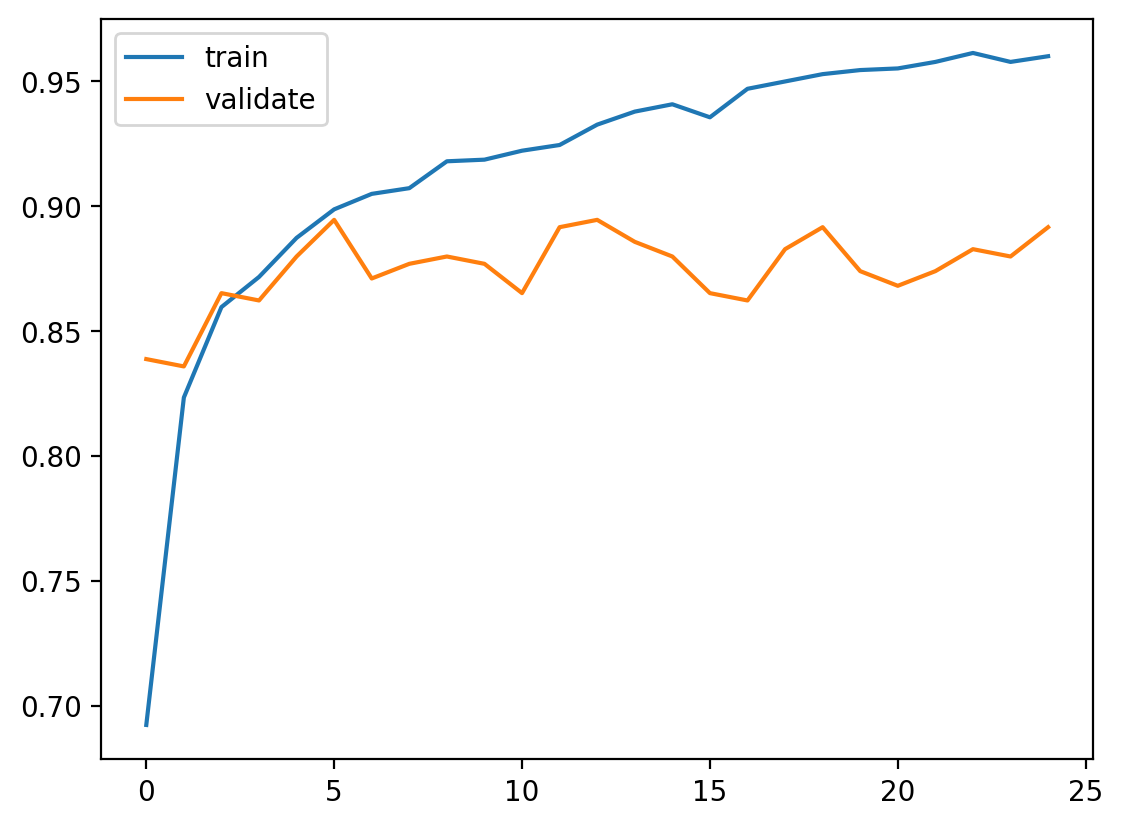

In [43]:
plt.plot(history.history['accuracy'], label="train")
plt.plot(history.history['val_accuracy'], label="validate")
plt.legend()
plt.show()

The best result showed the model on the epoch #6.